# 02 - 设备分析 (Device Table) — 2025年至今

分析 OSAIO (`bi_center`) 和 Nooie (`nooie_bi_center`) 的 `device` 表

**数据范围：2025-01-01 至今**

**分析维度：**
1. 设备创建趋势（按月）
2. 设备型号分布（Top 20 model_code）
3. 设备在线状态分析
4. 设备健康度分析 - 每月新增设备中30天+未在线占比
5. OSAIO vs Nooie 综合对比

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar
from datetime import datetime, timedelta

from src.db.connector import DBConnector

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

/Users/petercheng/Library/Python/3.9/lib/python/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/Users/petercheng/Library/Python/3.9/lib/python/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# 建立连接
db = DBConnector(brand='osaio')
db.connect()
print('Connected to:', db.database)

Connected to: bi_center


## 1. 加载数据

In [3]:
# 加载两个品牌的设备数据（2025年以后创建的设备）
sql = """
SELECT 
    uuid,
    model_code,
    mq_online,
    p2p_online,
    online_time,
    create_time
FROM device
WHERE create_time >= 1735689600
"""

# OSAIO
df_osaio = db.query_df(sql)
df_osaio['brand'] = 'OSAIO'
print(f'OSAIO: {len(df_osaio):,} devices')

# Nooie
db.switch_database('nooie')
df_nooie = db.query_df(sql)
df_nooie['brand'] = 'Nooie'
print(f'Nooie: {len(df_nooie):,} devices')

# 合并
df = pd.concat([df_osaio, df_nooie], ignore_index=True)
print(f'Total: {len(df):,} devices')

# 预处理时间字段
df['create_date'] = pd.to_datetime(df['create_time'], unit='s')
df['create_month'] = df['create_date'].dt.to_period('M')

# online_time 是毫秒时间戳
df['online_date'] = pd.to_datetime(df['online_time'], unit='ms', errors='coerce')

# 在线状态（MQ或P2P任一在线）
df['is_online'] = ((df['mq_online'] == 1) | (df['p2p_online'] == 1)).astype(int)

print(f"\n时间范围: {df['create_date'].min()} ~ {df['create_date'].max()}")
print(f"在线设备: {df['is_online'].sum():,} ({df['is_online'].sum()/len(df)*100:.1f}%)")
df.head()

OSAIO: 197,166 devices


Nooie: 30,965 devices
Total: 228,131 devices

时间范围: 2025-01-01 00:39:55 ~ 2026-02-16 22:40:13
在线设备: 122,712 (53.8%)


,uuid,model_code,mq_online,p2p_online,online_time,create_time,brand,create_date,create_month,online_date,is_online
0,000079a1e16b8d3e35ba21f4b1adc200,GP5_T6S8A3,0,0,1770816829312,1757655614,OSAIO,2025-09-12 05:40:14,2025-09,2026-02-11 13:33:49.312,0
1,00009641e19435379f0f24d90f40b377,GP5_T6S8A3,0,0,1763154837657,1747077673,OSAIO,2025-05-12 19:21:13,2025-05,2025-11-14 21:13:57.657,0
2,0000d073e10e69e205c8bd3754ecc593,GP5_T6S8A3,0,0,1766753105269,1763666714,OSAIO,2025-11-20 19:25:14,2025-11,2025-12-26 12:45:05.269,0
3,000136c9e1d1740e102b362f1f140f1f,GP5_T6S8A3,1,1,1771268141413,1767106700,OSAIO,2025-12-30 14:58:20,2025-12,2026-02-16 18:55:41.413,1
4,0001a980d178555d223fe77d3c6b84f0,T1PRO_A4J6A3,1,1,1770889320854,1748974278,OSAIO,2025-06-03 18:11:18,2025-06,2026-02-12 09:42:00.854,1


## 2. 设备创建趋势

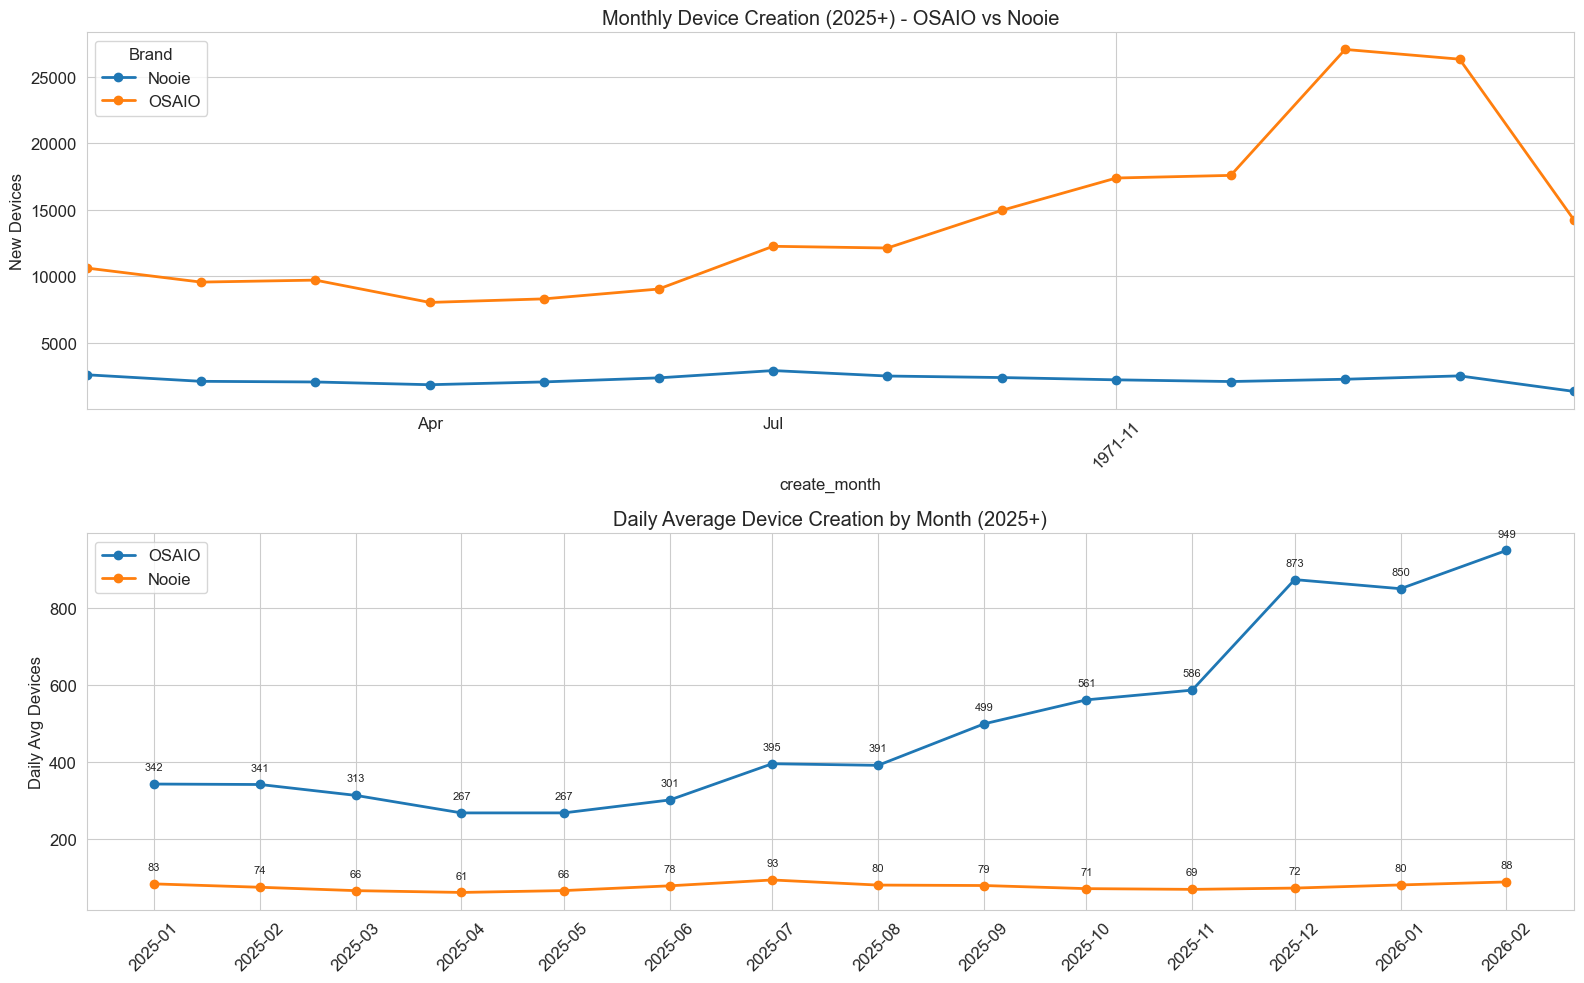


Monthly Creation Summary:


brand,Nooie,OSAIO,Total
create_month,,,
2025-01,2577,10614,13191
2025-02,2083,9554,11637
2025-03,2034,9703,11737
2025-04,1828,8023,9851
2025-05,2039,8292,10331
2025-06,2344,9032,11376
2025-07,2893,12249,15142
2025-08,2482,12120,14602
2025-09,2367,14957,17324


In [4]:
# 月度创建趋势 - OSAIO vs Nooie
monthly = df.groupby(['create_month', 'brand']).size().unstack(fill_value=0)

# 日均量（处理当前不完整月）
today = pd.Timestamp.now().normalize()
yesterday = today - pd.Timedelta(days=1)
current_month = today.to_period('M')
elapsed_days = yesterday.day

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 月度总量
monthly_ts = monthly.copy()
monthly_ts.index = monthly_ts.index.to_timestamp()
monthly_ts.plot(ax=axes[0], marker='o', linewidth=2, markersize=6)
axes[0].set_title('Monthly Device Creation (2025+) - OSAIO vs Nooie')
axes[0].set_ylabel('New Devices')
axes[0].legend(title='Brand')
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0].tick_params(axis='x', rotation=45)

# 日均创建量
for brand in ['OSAIO', 'Nooie']:
    brand_monthly = df[df['brand'] == brand].groupby('create_month').size()
    daily_avg = pd.DataFrame({'total': brand_monthly})
    daily_avg['days'] = daily_avg.index.map(
        lambda p: elapsed_days if p == current_month
        else calendar.monthrange(p.year, p.month)[1]
    )
    daily_avg['daily_avg'] = daily_avg['total'] / daily_avg['days']
    daily_avg.index = daily_avg.index.to_timestamp()
    axes[1].plot(daily_avg.index, daily_avg['daily_avg'], label=brand, marker='o', linewidth=2, markersize=6)
    for idx, row in daily_avg.iterrows():
        axes[1].annotate(f"{row['daily_avg']:.0f}", (idx, row['daily_avg']),
                        textcoords='offset points', xytext=(0, 10), ha='center', fontsize=8)

axes[1].set_title('Daily Average Device Creation by Month (2025+)')
axes[1].set_ylabel('Daily Avg Devices')
axes[1].legend()
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/device_creation_trend.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nMonthly Creation Summary:')
monthly['Total'] = monthly.sum(axis=1)
monthly

## 3. 设备型号分布 (Top 20)

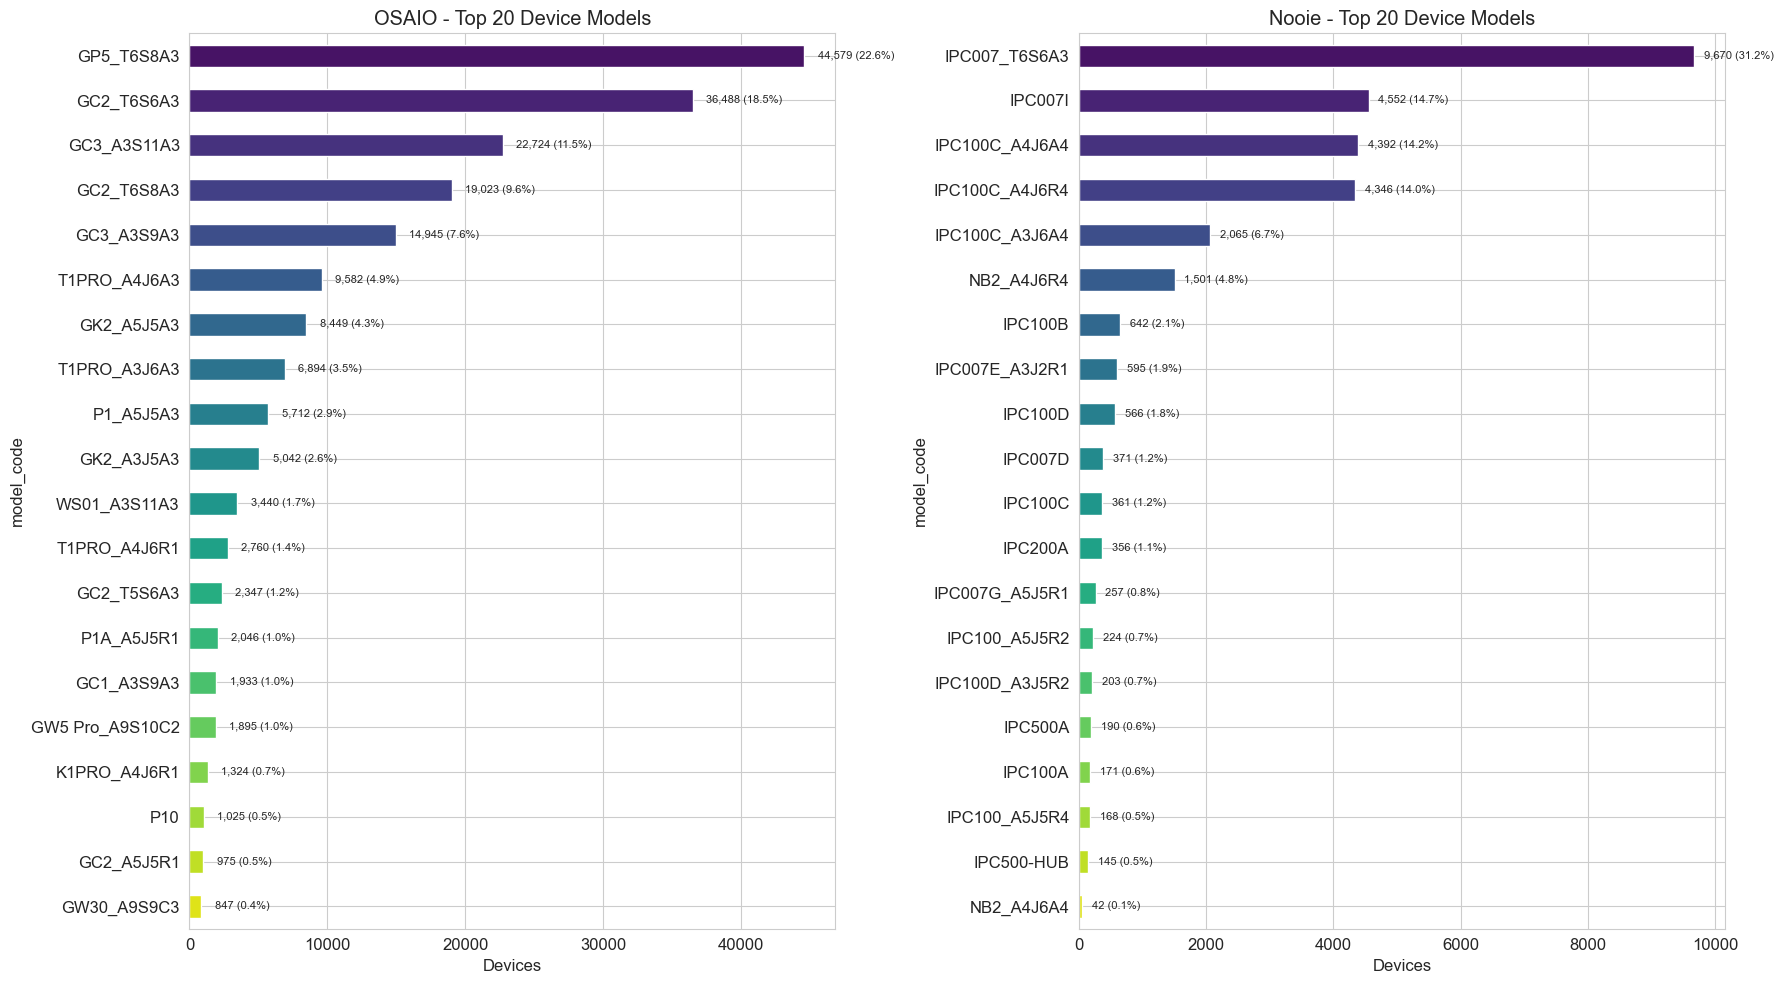


OSAIO - Top 20 Device Models:


,model_code,devices,pct,cumulative_pct,online_rate_%
0,GP5_T6S8A3,44579,22.61,22.61,57.30
1,GC2_T6S6A3,36488,18.51,41.12,43.60
2,GC3_A3S11A3,22724,11.53,52.65,62.40
3,GC2_T6S8A3,19023,9.65,62.30,58.00
4,GC3_A3S9A3,14945,7.58,69.88,52.70
5,T1PRO_A4J6A3,9582,4.86,74.74,60.80
6,GK2_A5J5A3,8449,4.29,79.03,70.20
7,T1PRO_A3J6A3,6894,3.50,82.53,66.40
8,P1_A5J5A3,5712,2.90,85.43,44.10
9,GK2_A3J5A3,5042,2.56,87.99,73.70


Unique models: 80

Nooie - Top 20 Device Models:


,model_code,devices,pct,cumulative_pct,online_rate_%
0,IPC007_T6S6A3,9670,31.23,31.23,41.10
1,IPC007I,4552,14.70,45.93,37.90
2,IPC100C_A4J6A4,4392,14.18,60.11,51.60
3,IPC100C_A4J6R4,4346,14.04,74.15,49.90
4,IPC100C_A3J6A4,2065,6.67,80.82,57.20
5,NB2_A4J6R4,1501,4.85,85.67,43.20
6,IPC100B,642,2.07,87.74,37.50
7,IPC007E_A3J2R1,595,1.92,89.66,26.40
8,IPC100D,566,1.83,91.49,45.40
9,IPC007D,371,1.20,92.69,34.50


Unique models: 34


In [5]:
# Top 20 设备型号 - 按品牌
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for i, brand in enumerate(['OSAIO', 'Nooie']):
    brand_df = df[df['brand'] == brand]
    model_dist = brand_df['model_code'].value_counts().head(20)
    
    model_dist.plot(kind='barh', ax=axes[i], color=sns.color_palette('viridis', 20))
    axes[i].set_title(f'{brand} - Top 20 Device Models')
    axes[i].set_xlabel('Devices')
    axes[i].invert_yaxis()
    
    # 标注数值和百分比
    total = len(brand_df)
    for j, (val, name) in enumerate(zip(model_dist.values, model_dist.index)):
        axes[i].text(val + total*0.005, j, f'{val:,} ({val/total*100:.1f}%)', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('../reports/device_model_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# 详细表格
for brand in ['OSAIO', 'Nooie']:
    brand_df = df[df['brand'] == brand]
    model_dist = brand_df['model_code'].value_counts().head(20).reset_index()
    model_dist.columns = ['model_code', 'devices']
    model_dist['pct'] = (model_dist['devices'] / len(brand_df) * 100).round(2)
    model_dist['cumulative_pct'] = model_dist['pct'].cumsum().round(2)
    
    # 在线率
    online_rates = []
    for mc in model_dist['model_code']:
        mc_df = brand_df[brand_df['model_code'] == mc]
        online_rate = mc_df['is_online'].sum() / len(mc_df) * 100
        online_rates.append(round(online_rate, 1))
    model_dist['online_rate_%'] = online_rates
    
    print(f'\n{brand} - Top 20 Device Models:')
    display(model_dist)
    print(f'Unique models: {brand_df["model_code"].nunique()}')

## 4. 设备在线状态分析

OSAIO: Online=109,046  Offline=88,120  Online Rate=55.3%
Nooie: Online=13,666  Offline=17,299  Online Rate=44.1%


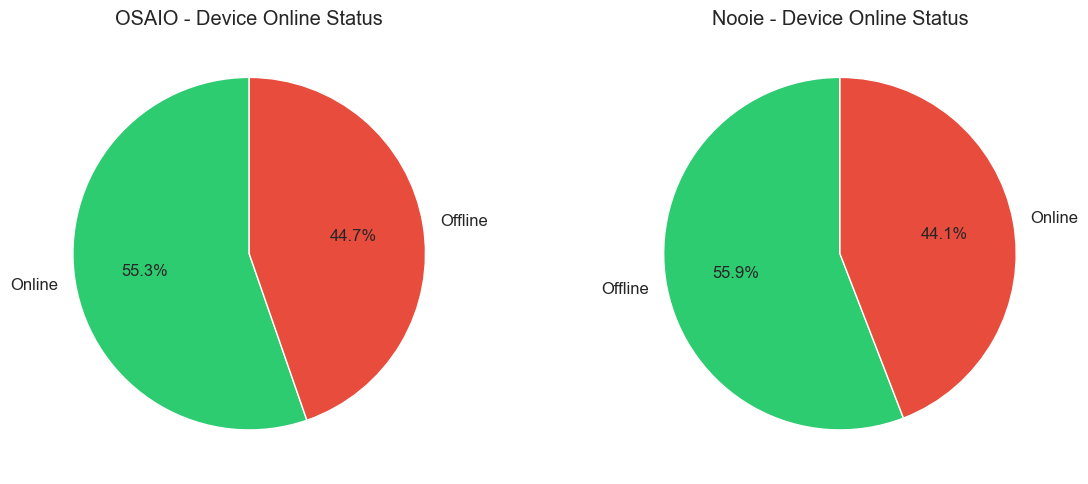

In [6]:
# 在线 vs 离线占比
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['#2ecc71', '#e74c3c']

for i, brand in enumerate(['OSAIO', 'Nooie']):
    brand_df = df[df['brand'] == brand]
    online_dist = brand_df['is_online'].map({1: 'Online', 0: 'Offline'}).value_counts()
    
    axes[i].pie(online_dist, labels=online_dist.index, autopct='%1.1f%%', 
                startangle=90, colors=colors[:len(online_dist)])
    axes[i].set_title(f'{brand} - Device Online Status')
    
    online_cnt = online_dist.get('Online', 0)
    offline_cnt = online_dist.get('Offline', 0)
    print(f'{brand}: Online={online_cnt:,}  Offline={offline_cnt:,}  '
          f'Online Rate={online_cnt/(online_cnt+offline_cnt)*100:.1f}%')

plt.tight_layout()
plt.savefig('../reports/device_online_status.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. 设备健康度分析 - 每月新增设备中30天+未在线占比

**定义**: 30天以上未在线的设备视为已废弃，不会再恢复在线。

**计算方法**: 对每个月新增的设备，计算其中最近30天以上未在线的占比。

# 计算每个设备距今的最后在线天数
now = pd.Timestamp.now()
df['days_since_online'] = (now - df['online_date']).dt.total_seconds() / 86400

# 设备是否为"废弃"状态（30天+未在线，或从未在线）
df['is_abandoned'] = ((df['days_since_online'] > 30) | df['online_date'].isna()).astype(int)

# 按创建月份统计废弃率
monthly_health = []

for brand in ['OSAIO', 'Nooie']:
    brand_df = df[df['brand'] == brand]
    
    for month in brand_df['create_month'].unique():
        month_devices = brand_df[brand_df['create_month'] == month]
        total = len(month_devices)
        abandoned = month_devices['is_abandoned'].sum()
        abandoned_rate = (abandoned / total * 100) if total > 0 else 0
        
        monthly_health.append({
            'brand': brand,
            'month': month,
            'total_devices': total,
            'abandoned_devices': abandoned,
            'abandoned_rate_%': round(abandoned_rate, 1)
        })

health_df = pd.DataFrame(monthly_health)
health_df = health_df.sort_values(['brand', 'month'])

# 可视化
fig, ax = plt.subplots(figsize=(16, 6))

for brand in ['OSAIO', 'Nooie']:
    brand_health = health_df[health_df['brand'] == brand].copy()
    brand_health['month_ts'] = brand_health['month'].apply(lambda x: x.to_timestamp())
    
    ax.plot(brand_health['month_ts'], brand_health['abandoned_rate_%'], 
            label=brand, marker='o', linewidth=2, markersize=6)
    
    # 标注数值
    for _, row in brand_health.iterrows():
        ax.annotate(f"{row['abandoned_rate_%']:.1f}%", 
                   (row['month_ts'], row['abandoned_rate_%']),
                   textcoords='offset points', xytext=(0, 10), 
                   ha='center', fontsize=8)

ax.set_title('Monthly Device Abandonment Rate (30+ Days Offline) - 2025+')
ax.set_xlabel('Creation Month')
ax.set_ylabel('Abandonment Rate (%)')
ax.legend()
ax.set_ylim(0, 100)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/device_abandonment_rate.png', dpi=150, bbox_inches='tight')
plt.show()

# 详细表格
for brand in ['OSAIO', 'Nooie']:
    brand_health = health_df[health_df['brand'] == brand]
    print(f'\n{brand} - Monthly Device Abandonment Rate (30+ Days Offline):')
    display(brand_health[['month', 'total_devices', 'abandoned_devices', 'abandoned_rate_%']])
    
    overall_rate = brand_health['abandoned_devices'].sum() / brand_health['total_devices'].sum() * 100
    print(f'Overall: {overall_rate:.1f}% abandonment rate')

## 6. OSAIO vs Nooie 综合对比

In [8]:
# 综合对比表
summary = {}
for brand in ['OSAIO', 'Nooie']:
    brand_df = df[df['brand'] == brand]
    brand_health = health_df[health_df['brand'] == brand]
    
    overall_abandon_rate = brand_health['abandoned_devices'].sum() / brand_health['total_devices'].sum() * 100
    
    summary[brand] = {
        'Total Devices': len(brand_df),
        'Online Devices': brand_df['is_online'].sum(),
        'Online Rate %': round(brand_df['is_online'].mean() * 100, 1),
        'Abandoned Devices (30+d)': brand_df['is_abandoned'].sum(),
        'Abandonment Rate %': round(overall_abandon_rate, 1),
        'Unique Models': brand_df['model_code'].nunique(),
        'Top Model': brand_df['model_code'].value_counts().index[0],
    }

summary_df = pd.DataFrame(summary)
print('OSAIO vs Nooie - Device Summary (2025+):')
summary_df

OSAIO vs Nooie - Device Summary (2025+):


,OSAIO,Nooie
Total Devices,197166,30965
Online Devices,109046,13666
Online Rate %,55.30,44.10
Abandoned Devices (30+d),57642,10989
Abandonment Rate %,29.20,35.50
Unique Models,80,34
Top Model,GP5_T6S8A3,IPC007_T6S6A3


## 7. 生成报告

In [9]:
# 生成 Markdown 报告
report = f"""# EU区设备分析报告 (2025年至今)

**生成时间**: {datetime.now().strftime('%Y-%m-%d %H:%M')}  
**数据范围**: 2025-01-01 至今

## 概览

| 指标 | OSAIO | Nooie |
|------|-------|-------|
| 总设备数 | {summary['OSAIO']['Total Devices']:,} | {summary['Nooie']['Total Devices']:,} |
| 在线设备 | {summary['OSAIO']['Online Devices']:,} | {summary['Nooie']['Online Devices']:,} |
| 在线率 | {summary['OSAIO']['Online Rate %']}% | {summary['Nooie']['Online Rate %']}% |
| 废弃设备 (30+天未在线) | {summary['OSAIO']['Abandoned Devices (30+d)']:,} | {summary['Nooie']['Abandoned Devices (30+d)']:,} |
| 废弃率 | {summary['OSAIO']['Abandonment Rate %']}% | {summary['Nooie']['Abandonment Rate %']}% |
| 设备型号数 | {summary['OSAIO']['Unique Models']} | {summary['Nooie']['Unique Models']} |
| Top型号 | {summary['OSAIO']['Top Model']} | {summary['Nooie']['Top Model']} |

## 关键洞察

1. **设备规模**: OSAIO设备数量是Nooie的 {summary['OSAIO']['Total Devices'] / summary['Nooie']['Total Devices']:.1f}倍
2. **在线率**: OSAIO ({summary['OSAIO']['Online Rate %']}%) 比 Nooie ({summary['Nooie']['Online Rate %']}%) 高 {summary['OSAIO']['Online Rate %'] - summary['Nooie']['Online Rate %']:.1f}个百分点
3. **设备健康度**: OSAIO废弃率 {summary['OSAIO']['Abandonment Rate %']}%, Nooie废弃率 {summary['Nooie']['Abandonment Rate %']}%

## 图表

- 创建趋势: `reports/device_creation_trend.png`
- 型号分布: `reports/device_model_distribution.png`
- 在线状态: `reports/device_online_status.png`
- 设备废弃率趋势: `reports/device_abandonment_rate.png`
"""

with open('../reports/02_device_analysis_report.md', 'w') as f:
    f.write(report)

print('Report saved to: reports/02_device_analysis_report.md')

Report saved to: reports/02_device_analysis_report.md


In [10]:
# 关闭连接
db.close()
print('Done!')

Done!
